In [20]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Count of images in each set

Number of images in train folder: 12601
Number of images in test folder: 5410


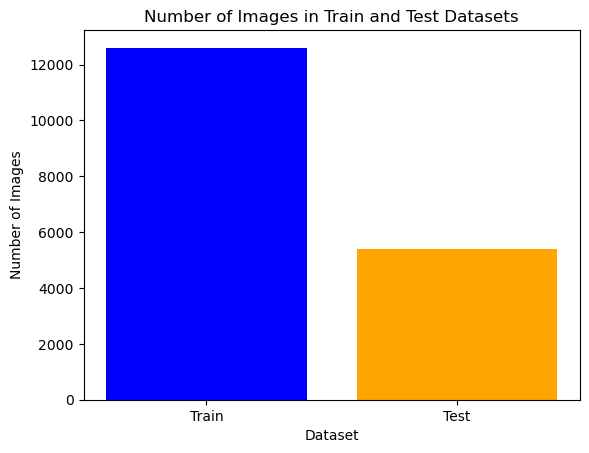

In [1]:

def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
                count += 1
    return count

# Define the paths to the train and test folders
train_folder_path = 'Human Action Recognition/train'
test_folder_path = 'Human Action Recognition/test'

# Count the images in each folder
train_image_count = count_images_in_folder(train_folder_path)
test_image_count = count_images_in_folder(test_folder_path)

# Print the counts
print(f'Number of images in train folder: {train_image_count}')
print(f'Number of images in test folder: {test_image_count}')

# Plotting the bar graph
labels = ['Train', 'Test']
counts = [train_image_count, test_image_count]

plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Number of Images in Train and Test Datasets')
plt.show()


### Copying the images and splitting based on class

In [2]:
# Configuration
csv_file_path = 'Human Action Recognition/Training_set.csv'  # Update with your CSV file path
base_directory = './Label-dataset/train'  # Update with your base directory path
images_directory = 'Human Action Recognition/train'  # Update with your images directory path

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Get unique labels
labels = df['label'].unique()

# Create directories for each label
for label in labels:
    label_dir = os.path.join(base_directory, str(label))
    os.makedirs(label_dir, exist_ok=True)

# Copy files to corresponding directories with progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Copying files"):
    file_name = row['filename']
    label = row['label']
    
    # Define the source and destination paths
    src_path = os.path.join(images_directory, file_name)
    dst_path = os.path.join(base_directory, str(label), file_name)
    
    # Copy the file
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"File {src_path} does not exist.")


Copying files: 100%|████████████████████████████████████████████████████████████| 12600/12600 [01:22<00:00, 152.80it/s]


### Distribution of Classes in train dataset

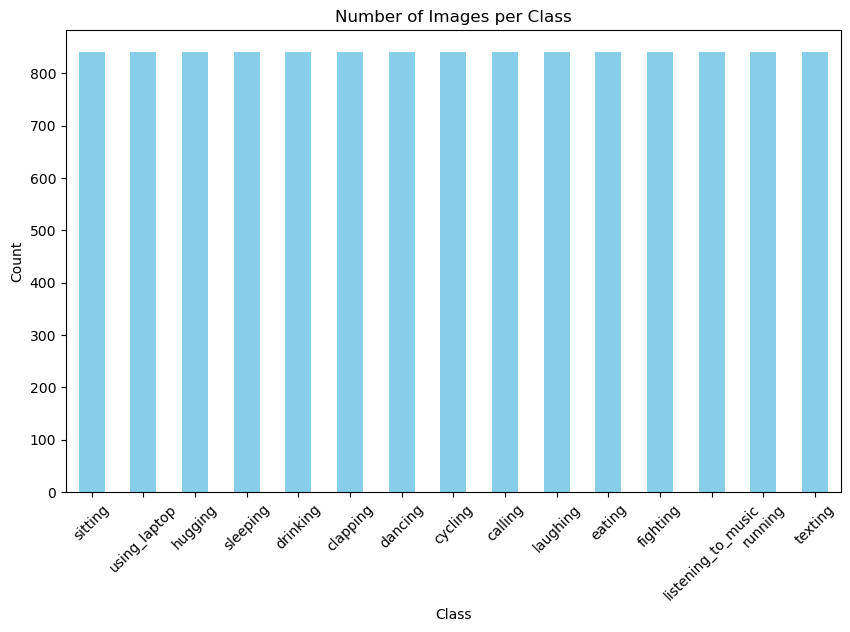

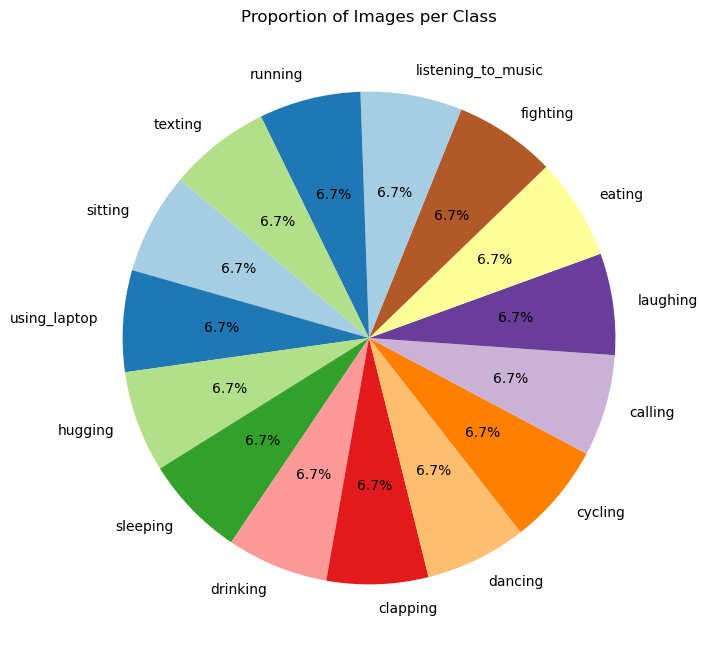

In [3]:
label_counts = df['label'].value_counts()

# Plot Bar Graph
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot Pie Chart
plt.figure(figsize=(8, 8))
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Proportion of Images per Class')
plt.ylabel('')  # Hides the 'y' label
plt.show()

#### Data preprocessing: Data augumentation

Found 10080 images belonging to 15 classes.
Found 2520 images belonging to 15 classes.


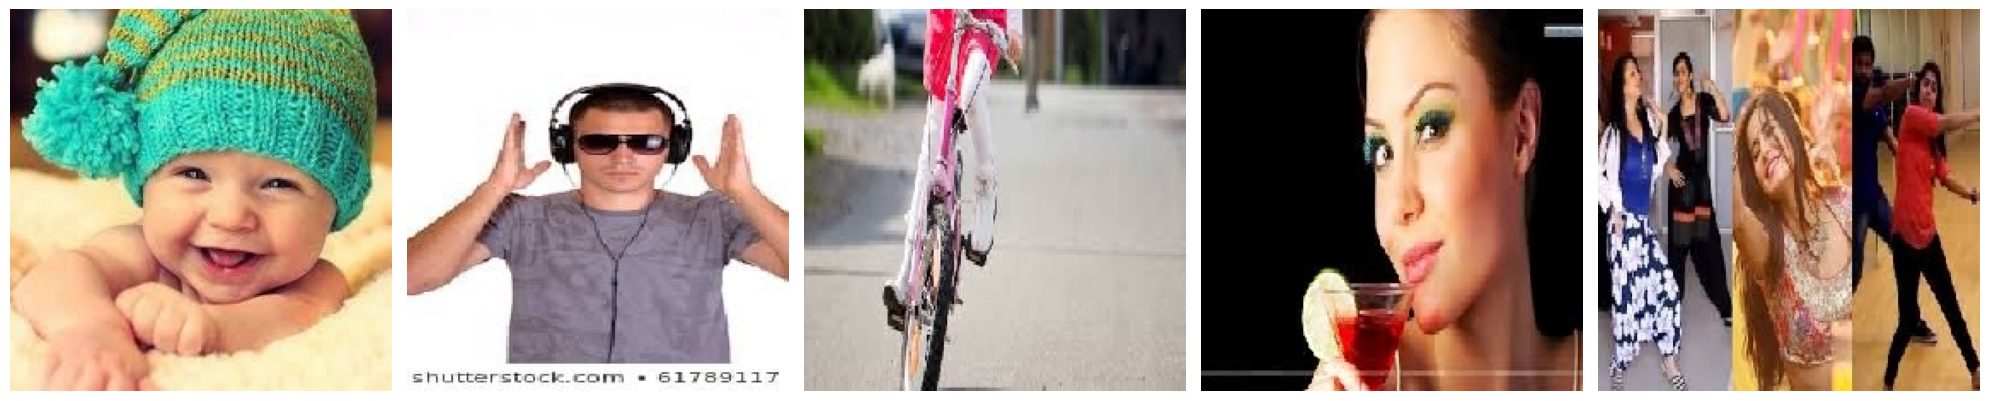

In [23]:
# Configuration
base_directory = './Label-dataset/train'  # The base directory where the images are stored

# Create an instance of ImageDataGenerator with data augmentation and validation split
datagen = ImageDataGenerator(p in
    rescale=1.0/255,  # Rescale pixel values to [0, 1]
    validation_split=0.2,  # Use 20% of the data for validation
)

# Create a data generator for the training set
train_generator = datagen.flow_from_directory(
    base_directory,
    target_size=(224, 224),  # Resize images to 256x256 pixels
    batch_size=32,  # Number of images to be yielded from the generator per batch
    color_mode='rgb',  # Images are in RGB format
    class_mode='categorical',  # Use 'categorical' if you have multiple classes
    subset='training'  # Set as training data
)

# Create a data generator for the validation set
validation_generator = datagen.flow_from_directory(
    base_directory,
    target_size=(224, 224),  # Resize images to 256x256 pixels
    batch_size=32,  # Number of images to be yielded from the generator per batch
    color_mode='rgb',  # Images are in RGB format
    class_mode='categorical',  # Use 'categorical' if you have multiple classes
    subset='validation'  # Set as validation data
)

test_generator = datagen.flow_from_directory(
    base_directory,
    target_size=(224, 224),  # Resize images to 256x256 pixels
    batch_size=32,  # Number of images to be yielded from the generator per batch
    color_mode='rgb',  # Images are in RGB format
    class_mode='categorical',  # Use 'categorical' if you have multiple classes
    subset='validation'  # Set as validation data
)

# Example of how to iterate through the training generator and plot images
images, labels = next(train_generator)

# Plot a few images from the batch
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
axes = axes.flatten()
for img, ax in zip(images[:5], axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


### Data preprocessing: Implement Alphapose  

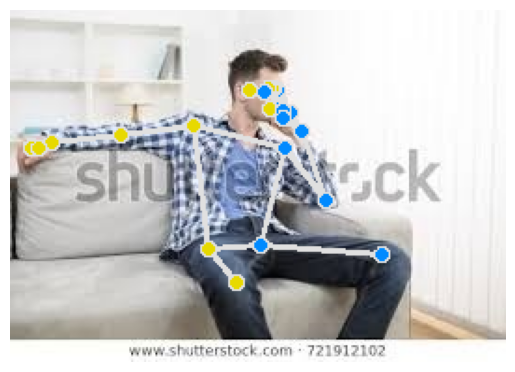

In [3]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mediapipe.framework.formats import landmark_pb2

# Function to draw landmarks on image
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        mp.solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            mp.solutions.pose.POSE_CONNECTIONS,
            mp.solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker_heavy.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("Image_33.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

# Display the image using Matplotlib
plt.imshow(annotated_image)
plt.axis('off')  # Turn off axis labels
plt.show()


In [6]:
detection_result

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.544193685054779, y=0.2602766454219818, z=-0.10686388611793518, visibility=0.9999605417251587, presence=0.999932050704956), NormalizedLandmark(x=0.5408633351325989, y=0.23031127452850342, z=-0.06837953627109528, visibility=0.9998226761817932, presence=0.9998247027397156), NormalizedLandmark(x=0.5407609343528748, y=0.23050612211227417, z=-0.06863200664520264, visibility=0.999778687953949, presence=0.9998396635055542), NormalizedLandmark(x=0.5408695340156555, y=0.2305089831352234, z=-0.06859336048364639, visibility=0.9998371601104736, presence=0.999783456325531), NormalizedLandmark(x=0.5331586003303528, y=0.22685760259628296, z=-0.10170917212963104, visibility=0.9999210834503174, presence=0.9998396635055542), NormalizedLandmark(x=0.5264008045196533, y=0.22520464658737183, z=-0.10199926793575287, visibility=0.9999191761016846, presence=0.9998763799667358), NormalizedLandmark(x=0.5192252397537231, y=0.22363191843032837, z=-0.10204

In [ ]:
import os
from tqdm import tqdm
input_dir = './Label-dataset/train'
output_dir = './keypoint-dataset/train'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process each image in the directory
for class_name in os.listdir(input_dir):
    class_dir = os.path.join(input_dir, class_name)
    if os.path.isdir(class_dir):
        # Create the corresponding output class directory
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        for image_name in tqdm(os.listdir(class_dir), desc=f'Processing {class_name}'):
            image_path = os.path.join(class_dir, image_name)
            output_image_path = os.path.join(output_class_dir, image_name)

            # Load the input image.
            image = mp.Image.create_from_file(image_path)

            # Detect pose landmarks from the input image.
            detection_result = detector.detect(image)

            # Process the detection result and draw landmarks on the image.
            annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

            # Save the annotated image
            cv2.imwrite(output_image_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Processing clapping:  55%|████████████████████████████████▎                          | 460/840 [00:47<00:36, 10.39it/s]

### Buliding Simple CNN model

In [5]:
# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # You can adjust the number of epochs
    verbose=1
)

Epoch 1/10
315/315 [==============================] - 86s 251ms/step - loss: 2.6481 - accuracy: 0.1346 - val_loss: 2.4084 - val_accuracy: 0.2198
Epoch 2/10
315/315 [==============================] - 35s 111ms/step - loss: 2.3194 - accuracy: 0.2440 - val_loss: 2.2838 - val_accuracy: 0.2667
Epoch 3/10
315/315 [==============================] - 34s 109ms/step - loss: 2.1171 - accuracy: 0.3169 - val_loss: 2.2058 - val_accuracy: 0.2849
Epoch 4/10
315/315 [==============================] - 35s 111ms/step - loss: 1.9594 - accuracy: 0.3678 - val_loss: 2.1305 - val_accuracy: 0.3087
Epoch 5/10
315/315 [==============================] - 35s 110ms/step - loss: 1.7694 - accuracy: 0.4432 - val_loss: 2.1655 - val_accuracy: 0.3079
Epoch 6/10
315/315 [==============================] - 34s 108ms/step - loss: 1.5570 - accuracy: 0.5171 - val_loss: 2.2426 - val_accuracy: 0.3187
Epoch 7/10
315/315 [==============================] - 34s 108ms/step - loss: 1.3454 - accuracy: 0.5956 - val_loss: 2.2880 - val_ac

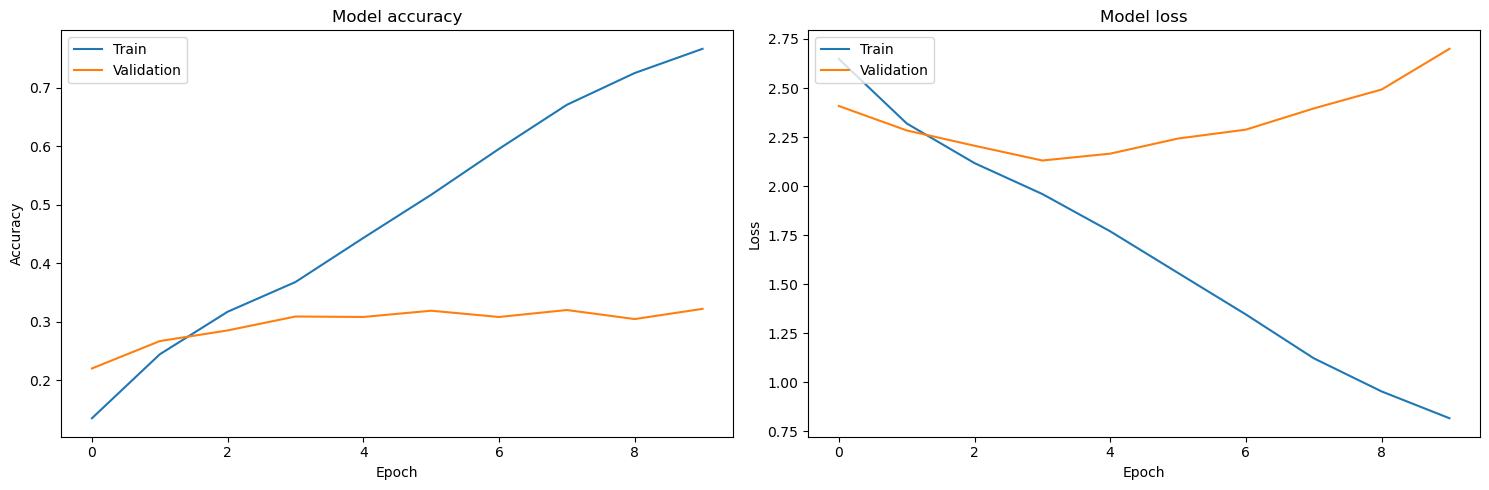

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [1]:
accruracy,loss = model.evaluate(test_generator,verbose=0)
print("CNN model accuracy:",accruracy)
print('CNN model Loss:',loss)

CNN model accuracy: 0.5324353
CNN model Loss: 2.334243


### Building MobilenetV2 model

In [7]:
# Load the MobileNetV2 model with pre-trained weights, excluding the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # You can adjust the number of epochs
    verbose=1
)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/10
315/315 [==============================] - 37s 107ms/step - loss: 1.6742 - accuracy: 0.4499 - val_loss: 1.4161 - val_accuracy: 0.5472
Epoch 2/10
315/315 [==============================] - 32s 102ms/step - loss: 1.3474 - accuracy: 0.5583 - val_loss: 1.3516 - val_accuracy: 0.5627
Epoch 3/10
315/315 [==============================] - 33s 103ms/step - loss: 1.2322 - accuracy: 0.5990 - val_loss: 1.3555 - val_accuracy: 0.5631
Epoch 4/10
315/315 [==============================] - 32s 103ms/step - loss: 1.1486 - accuracy: 0.6196 - val_loss: 1.2489 - val_accuracy: 0.6079
Epoch 5/10
315/315 [==============================] - 32s 102ms/step - loss: 1.0783 - accuracy: 0.6460 - val_loss: 1.2966 - val_accuracy: 0.5746
Epoch 6/10
315/315 [==============================] - 32s 103ms/step - loss: 1.0233 - accuracy: 0.6640 - val_loss: 1.3147 - val_accuracy: 0.5929
Epoch 7/10
315/315 [==============================] - 32s 103ms/ste

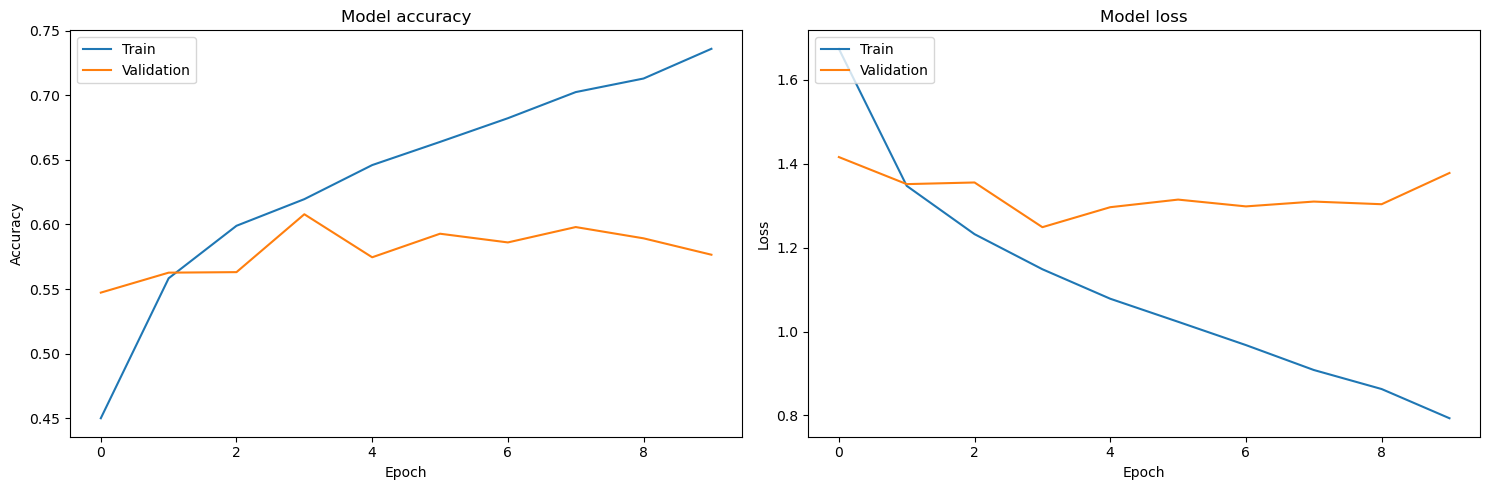

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [3]:
accruracy,loss = model.evaluate(test_generator,verbose=0)
print("MobileNetV2 model accuracy:",accruracy)
print('MobileNetV2 model Loss:',loss)

MobileNetV2 model accuracy: 0.7524353
MobileNetV2 model Loss: 1.3829


### Combining Image dataset and Alphapose dataset.

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import tensorflow as tf

# Initialize Mediapipe PoseLandmarker
base_options = mp.tasks.BaseOptions(model_asset_path='pose_landmarker_heavy.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)
def extract_landmarks(image_path):
    image = mp.Image.create_from_file(image_path)
    detection_result = detector.detect(image)
    
    landmarks_array = []
    if detection_result.pose_landmarks:
        for pose_landmarks in detection_result.pose_landmarks:
            for landmark in pose_landmarks:
                landmarks_array.extend([landmark.x, landmark.y, landmark.z])
    else:
        landmarks_array = [0] * 99  # Handle case when no landmarks are detected (33 keypoints * 3 coordinates)

    return np.array(landmarks_array)

def load_image_and_landmarks(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0  # Normalize to [0, 1]

    # Assuming landmarks are not part of the image file; replace this with actual landmark loading if needed
    landmark = tf.zeros([99], dtype=tf.float32)  # Placeholder for landmarks
    
    return img, landmark, label


In [14]:
from pathlib import Path
import numpy as np
import tensorflow as tf

def load_data(image_dir):
    image_paths = []
    labels = []

    image_dir = Path(image_dir)
    
    for folder in image_dir.iterdir():
        if folder.is_dir():
            for file in folder.iterdir():
                if file.suffix == ".jpg":
                    image_paths.append(str(file))
                    labels.append(folder.name)  # Use folder name as label

    return image_paths, labels

def process_path(file_path, label):
    img, landmark, label = tf.py_function(load_image_and_landmarks, [file_path, label], [tf.float32, tf.float32, tf.float32])
    img.set_shape((224, 224, 3))
    landmark.set_shape((99,))
    label.set_shape((num_classes,))  # Ensure the label shape matches the one-hot encoding
    return (img, landmark), label

def prepare_dataset(image_paths, labels, batch_size=32, buffer_size=1000):
    global num_classes  # Declare num_classes as global to access it in process_path
    unique_labels = np.unique(labels)
    label_to_index = {label: index for index, label in enumerate(unique_labels)}
    labels = np.array([label_to_index[label] for label in labels])
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(unique_labels))
    
    num_classes = len(unique_labels)  # Define num_classes here

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x, y: ((x[0], x[1]), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset, num_classes

# Load image paths and labels
image_dir = './Label-dataset/train/'
image_paths, labels = load_data(image_dir)

# Prepare the dataset
batch_size = 32
dataset, num_classes = prepare_dataset(image_paths, labels, batch_size)
def split_dataset(dataset, split_ratios=(0.7, 0.2, 0.1)):
    # Calculate the sizes for each split
    dataset_size = sum(1 for _ in dataset)
    train_size = int(split_ratios[0] * dataset_size)
    val_size = int(split_ratios[1] * dataset_size)
    
    # Shuffle dataset
    dataset = dataset.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=False)

    # Split dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)
    
    return train_dataset, val_dataset, test_dataset

# Split the dataset into training, validation, and test sets
split_ratios = (0.7, 0.2, 0.1)  # 70% training, 20% validation, 10% test
train_dataset, val_dataset, test_dataset = split_dataset(dataset, split_ratios)

In [15]:
def load_data(image_dir):
    image_paths = []
    labels = []

    image_dir = Path(image_dir)
    
    for folder in image_dir.iterdir():
        if folder.is_dir():
            for file in folder.iterdir():
                if file.suffix == ".jpg":
                    image_paths.append(str(file))
                    labels.append(folder.name)  # Use folder name as label

    return image_paths, labels
def load_image_and_landmarks(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0  # Normalize to [0, 1]

    # Assuming landmarks are not part of the image file; replace this with actual landmark loading if needed
    landmark = tf.zeros([99], dtype=tf.float32)  # Placeholder for landmarks
    
    return img, landmark, label
for file_path, label in zip(image_paths[:5], labels[:5]):  # Check first 5 samples
    img, landmark, label = load_image_and_landmarks(file_path, label)
    print("Image shape:", img.shape)
    print("Landmark shape:", landmark.shape)
    print("Label:", label)


Image shape: (224, 224, 3)
Landmark shape: (99,)
Label: calling
Image shape: (224, 224, 3)
Landmark shape: (99,)
Label: calling
Image shape: (224, 224, 3)
Landmark shape: (99,)
Label: calling
Image shape: (224, 224, 3)
Landmark shape: (99,)
Label: calling
Image shape: (224, 224, 3)
Landmark shape: (99,)
Label: calling


In [16]:
for (img, landmark), label in train_dataset.take(1):
    print("Image shape:", img.shape)
    print("Landmark shape:", landmark.shape)
    print("Label shape:", label.shape)


Image shape: (32, 224, 224, 3)
Landmark shape: (32, 99)
Label shape: (32, 15)


### Custom CNN model 

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Conv2D, MaxPooling2D, Dropout

# Image input branch
image_input = Input(shape=(224, 224, 3), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Landmarks input branch
landmarks_input = Input(shape=(99,), name='landmarks_input')
y = Dense(128, activation='relu')(landmarks_input)
y = Dense(64, activation='relu')(y)

# Combine branches
combined = Concatenate()([x, y])
z = Dense(512, activation='relu')(combined)
z = Dense(256, activation='relu')(combined)
z = Dense(num_classes, activation='softmax')(z)

# Define the model
model = Model(inputs=[image_input, landmarks_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 222, 222, 32  896         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d_18 (MaxPooling2D  (None, 111, 111, 32  0          ['conv2d_18[0][0]']              
 )                              )                                                           

In [36]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset  # Replace with a validation dataset if available
)

Epoch 1/10
315/315 [==============================] - 23s 71ms/step - loss: 2.6753 - accuracy: 0.1577 - val_loss: 2.3671 - val_accuracy: 0.2377
Epoch 2/10
315/315 [==============================] - 23s 71ms/step - loss: 2.1331 - accuracy: 0.3200 - val_loss: 2.2816 - val_accuracy: 0.2714
Epoch 3/10
315/315 [==============================] - 23s 71ms/step - loss: 1.5359 - accuracy: 0.5175 - val_loss: 2.3966 - val_accuracy: 0.4897
Epoch 4/10
315/315 [==============================] - 23s 71ms/step - loss: 0.6661 - accuracy: 0.7902 - val_loss: 1.4375 - val_accuracy: 0.5778
Epoch 5/10
315/315 [==============================] - 23s 71ms/step - loss: 0.2383 - accuracy: 0.9299 - val_loss: 1.0822 - val_accuracy: 0.5583
Epoch 6/10
315/315 [==============================] - 23s 71ms/step - loss: 0.1462 - accuracy: 0.9615 - val_loss: 0.6202 - val_accuracy: 0.6615
Epoch 7/10
315/315 [==============================] - 23s 71ms/step - loss: 0.0951 - accuracy: 0.9738 - val_loss: 0.3837 - val_accuracy:

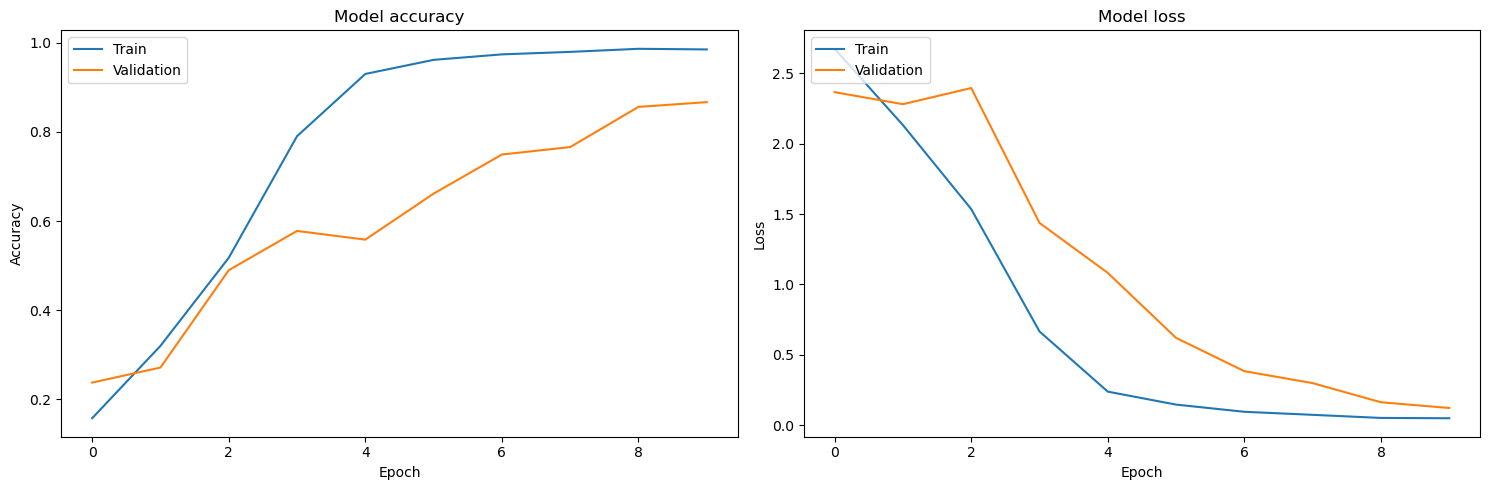

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax[0].plot(history['accuracy'])
ax[0].plot(history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(history['loss'])
ax[1].plot(history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [4]:
accruracy,loss = model.evaluate(test_dataset,verbose=0)
print("CNN model with alphapose accuracy:",accruracy)
print('CNN model with alphapose Loss:',loss)

CNN model with alphapose accuracy: 0.83297
CNN model with alphapose Loss: 0.942732


### Proposed Model

In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout

# Define MobileNetV2 as a feature extractor
def build_model(num_classes):
    # Image input branch with MobileNetV2
    image_input = Input(shape=(224, 224, 3), name='image_input')
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input, pooling='avg')
    x = base_model.output
    x = Flatten()(x)  # Flatten output of MobileNetV2

    # Landmarks input branch
    landmarks_input = Input(shape=(99,), name='landmarks_input')
    y = Dense(128, activation='relu')(landmarks_input)
    y = Dense(64, activation='relu')(y)

    # Combine branches
    combined = Concatenate()([x, y])
    z = Dense(512, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(256, activation='relu')(z)
    z = Dense(num_classes, activation='softmax')(z)

    # Define the model
    model = Model(inputs=[image_input, landmarks_input], outputs=z)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model with the number of classes
model = build_model(num_classes)

# Summary of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
          

 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_

 block_14_expand_relu (ReLU)    (None, 7, 7, 960)    0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_

                                                                                                  
 dropout_5 (Dropout)            (None, 512)          0           ['dense_22[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 256)          131328      ['dropout_5[0][0]']              
                                                                                                  
 dense_24 (Dense)               (None, 15)           3855        ['dense_23[0][0]']               
                                                                                                  
Total params: 3,102,863
Trainable params: 3,068,751
Non-trainable params: 34,112
__________________________________________________________________________________________________


In [44]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=train_dataset  # Replace with a validation dataset if available
)

Epoch 1/10
315/315 [==============================] - 23s 71ms/step - loss: 0.9675 - accuracy: 0.5377 - val_loss: 1.1267 - val_accuracy: 0.5070
Epoch 2/10
315/315 [==============================] - 23s 71ms/step - loss: 0.8133 - accuracy: 0.6800 - val_loss: 0.9282 - val_accuracy: 0.6614
Epoch 3/10
315/315 [==============================] - 23s 71ms/step - loss: 0.7536 - accuracy: 0.7575 - val_loss: 0.8966 - val_accuracy: 0.7097
Epoch 4/10
315/315 [==============================] - 23s 71ms/step - loss: 0.6661 - accuracy: 0.8502 - val_loss: 0.6438 - val_accuracy: 0.8378
Epoch 5/10
315/315 [==============================] - 23s 71ms/step - loss: 0.2283 - accuracy: 0.9390 - val_loss: 0.5216 - val_accuracy: 0.8983
Epoch 6/10
315/315 [==============================] - 23s 71ms/step - loss: 0.1262 - accuracy: 0.9715 - val_loss: 0.2021 - val_accuracy: 0.9415
Epoch 7/10
315/315 [==============================] - 23s 71ms/step - loss: 0.0895 - accuracy: 0.9738 - val_loss: 0.1370 - val_accuracy:

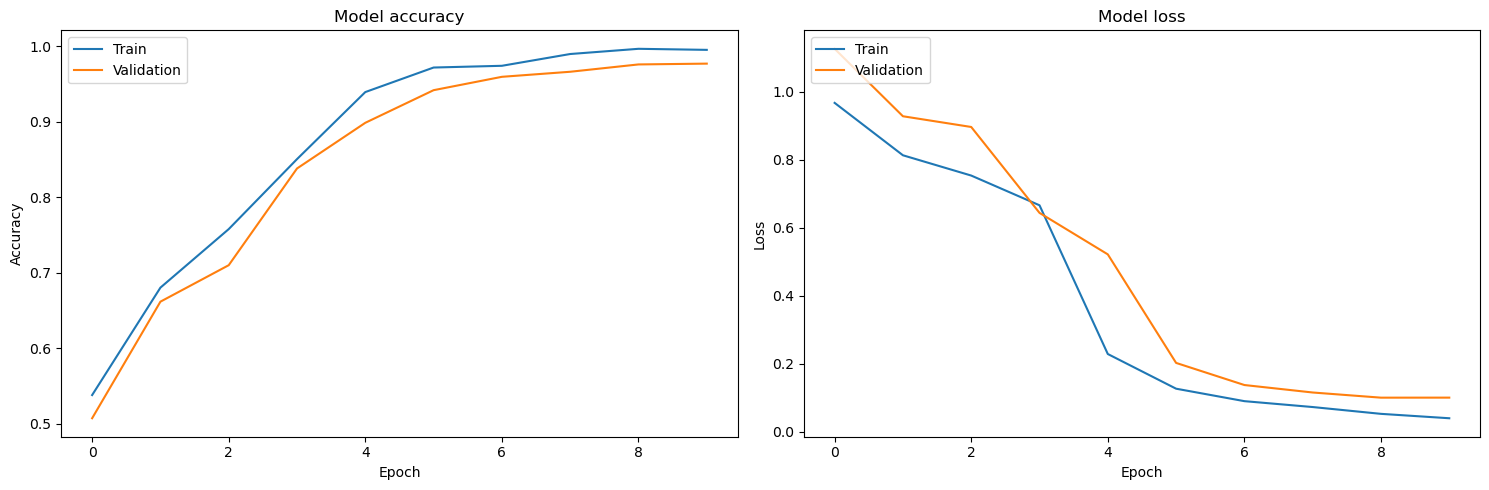

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax[0].plot(history['accuracy'])
ax[0].plot(history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(history['loss'])
ax[1].plot(history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [5]:
accruracy,loss = model.evaluate(test_generator,verbose=0)
print("MobileNetV2 Model with Alphapose accuracy:",accruracy)
print('MobileNetV2 Model with Alphapose Loss:',loss)

MobileNetV2 Model with Alphapose accuracy: 0.97653
MobileNetV2 Model with Alphapose Loss: 0.32245


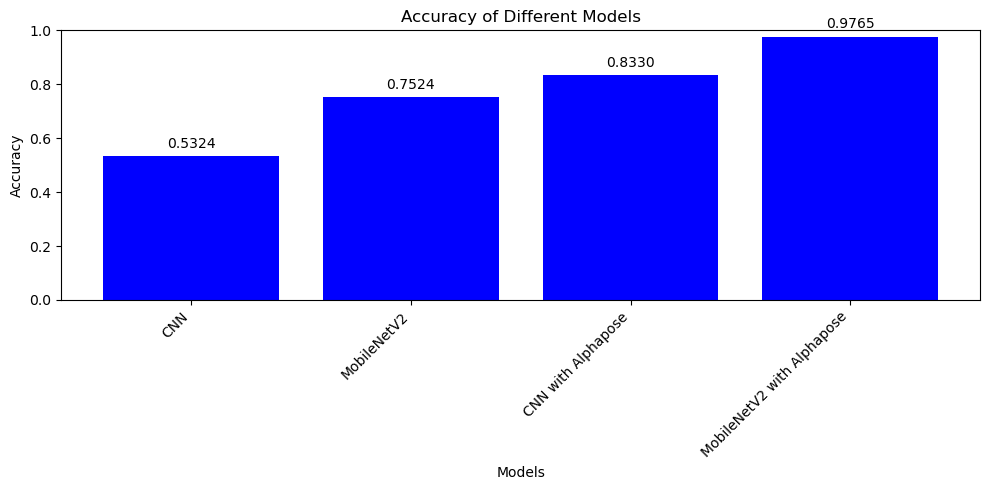

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['CNN', 'MobileNetV2', 'CNN with Alphapose', 'MobileNetV2 with Alphapose']
accuracy = [0.5324353, 0.7524353, 0.83297, 0.976530]

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.bar(models, accuracy, color='b')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)  # Accuracy typically ranges from 0 to 1

# Adding value labels
for i, v in enumerate(accuracy):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
